In [2]:
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
import skimage.segmentation as seg 
#import deeplabcut
#deeplabcut.utils.plotting.PlottingResults
import matplotlib.patches as patches
import matplotlib.path as mpath
Path = mpath.Path
from scipy.signal import find_peaks

In [3]:
#PARAMETROS
fase = "92h" # sana /92h / 7d / 14d / 28d
rata = fase+'_H1'
video = rata+'.mp4'
img_name = rata+".png" #para segmentacion
DLCscorer='DLC_resnet50_r3May10shuffle1_900000'
h5 = rata+DLCscorer+'.h5'
csv = rata+DLCscorer+'.csv'

#quiere recortar (1s = 30)
inicio = 1 #minimo valor 1
end = 40
w = 5





In [4]:
#CARGAMOS FICHERO H5 (ROI)
#video='GH010103.mp4'
#DLCscorer='DLC_resnet50_r3May10shuffle1_730000'

#dataname = str(Path(video).stem) + DLCscorer + '.h5'

#loading output of DLC
#Dataframe = pd.read_hdf(os.path.join(dataname))
Dataframe = pd.read_hdf("C:\\Users\\ainho\\OneDrive\\Escritorio\\UPM4\\TFG\\mi_codigo\\testing\\"+fase+"\\"+str(h5))
Dataframe.head()

scorer    DLC_resnet50_r3May10shuffle1_900000                         \
bodyparts                                toe1                          
coords                                      x           y likelihood   
0                                 2766.459961  331.942108   0.502292   
1                                 2563.812500  336.756836   0.141975   
2                                 2526.448730  331.304932   0.571345   
3                                 2477.660645  359.481812   0.659413   
4                                 2803.270020  378.296204   0.188783   

scorer                                                                  \
bodyparts       ankle1                               pata1               
coords               x           y likelihood            x           y   
0          2757.931152  326.013855   0.409876  2741.148438  311.563324   
1          2596.870361  328.017029   0.130888  2864.309082  312.575989   
2          2541.830811  321.845245   0.812564  2584.047119  316.732788   
3          2483.675781  346.390045   0.151977  2831.901611  302.809479   
4          2483.560547  377.896729   0.531523  2521.412598  330.707794   

scorer                             ...                                      \
bodyparts                    toe2  ...                    mtp2               
coords    likelihood            x  ... likelihood            x           y   
0           0.487441  2901.125244  ...   0.974921  2828.326172  330.382782   
1           0.328045  2901.142090  ...   0.788554  2813.191406  356.227570   
2           0.632415  2901.879395  ...   0.816602  2825.541260  341.014557   
3           0.049252  2804.295410  ...   0.590154  2839.927979  334.089935   
4           0.101695  2805.645264  ...   0.548737  2827.546631  336.126770   

scorer                                                                 \
bodyparts                  ankle2                               pata2   
coords    likelihood            x           y likelihood            x   
0           0.547155  2875.483887  320.558258   0.952119  2865.198975   
1           0.060455  2871.959717  318.838745   0.850972  2853.511963   
2           0.136850  2867.519531  316.478424   0.987647  2844.275146   
3           0.369918  2866.355957  310.617706   0.979537  2836.536133   
4           0.647587  2860.908936  314.761658   0.988607  2823.363281   

scorer                            
bodyparts                         
coords              y likelihood  
0          289.503510   0.579026  
1          296.369019   0.752853  
2          290.442047   0.761432  
3          287.100830   0.931540  
4          289.053802   0.802596  

[5 rows x 21 columns]

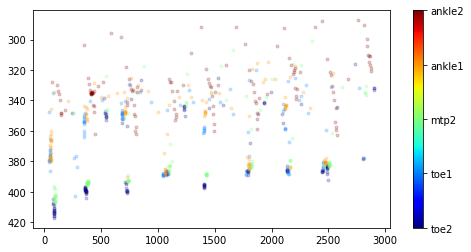

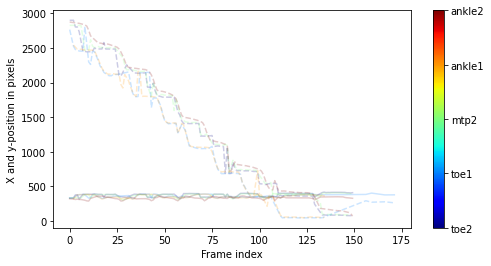

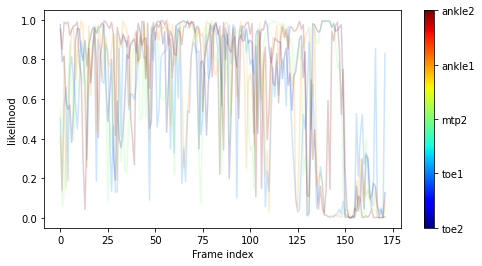

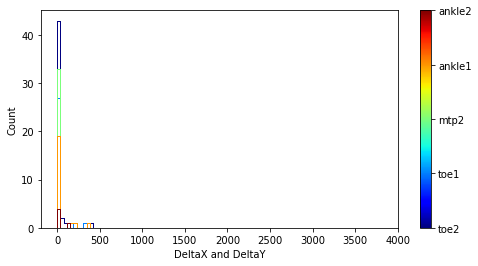

In [28]:
#RESULTADOS DLC
def get_cmap(n, name='hsv'):
    return plt.cm.get_cmap(name, n)

def Histogram(vector,color,bins):
    dvector=np.diff(vector)
    dvector=dvector[np.isfinite(dvector)]
    plt.hist(dvector,color=color,histtype='step',bins=bins)

def PlottingResults(Dataframe,bodyparts2plot,alphavalue=0.001,pcutoff=.5,colormap='jet',fs=(4,3)):
    ''' Plots poses vs time; pose x vs pose y; histogram of differences and likelihoods.'''
    plt.figure(figsize=fs)
    colors = get_cmap(len(bodyparts2plot),name = colormap)
    scorer=Dataframe.columns.get_level_values(0)[0] #you can read out the header to get the scorer name!

    for bpindex, bp in enumerate(bodyparts2plot):
        Index=Dataframe[scorer][bp]['likelihood'].values > pcutoff
        plt.plot(Dataframe[scorer][bp]['x'].values[Index],Dataframe[scorer][bp]['y'].values[Index],'.',color=colors(bpindex),alpha=alphavalue)

    plt.gca().invert_yaxis()

    sm = plt.cm.ScalarMappable(cmap=plt.get_cmap(colormap), norm=plt.Normalize(vmin=0, vmax=len(bodyparts2plot)-1))
    sm._A = []
    cbar = plt.colorbar(sm,ticks=range(len(bodyparts2plot)))
    cbar.set_ticklabels(bodyparts2plot)
    #plt.savefig(os.path.join(tmpfolder,"trajectory"+suffix))
    plt.figure(figsize=fs)
    Time=np.arange(np.size(Dataframe[scorer][bodyparts2plot[0]]['x'].values))

    for bpindex, bp in enumerate(bodyparts2plot):
        Index=Dataframe[scorer][bp]['likelihood'].values > pcutoff
        plt.plot(Time[Index],Dataframe[scorer][bp]['x'].values[Index],'--',color=colors(bpindex),alpha=alphavalue)
        plt.plot(Time[Index],Dataframe[scorer][bp]['y'].values[Index],'-',color=colors(bpindex),alpha=alphavalue)

    sm = plt.cm.ScalarMappable(cmap=plt.get_cmap(colormap), norm=plt.Normalize(vmin=0, vmax=len(bodyparts2plot)-1))
    sm._A = []
    cbar = plt.colorbar(sm,ticks=range(len(bodyparts2plot)))
    cbar.set_ticklabels(bodyparts2plot)
    plt.xlabel('Frame index')
    plt.ylabel('X and y-position in pixels')
    #plt.savefig(os.path.join(tmpfolder,"plot"+suffix))

    plt.figure(figsize=fs)
    for bpindex, bp in enumerate(bodyparts2plot):
        Index=Dataframe[scorer][bp]['likelihood'].values > pcutoff
        plt.plot(Time,Dataframe[scorer][bp]['likelihood'].values,'-',color=colors(bpindex),alpha=alphavalue)

    sm = plt.cm.ScalarMappable(cmap=plt.get_cmap(colormap), norm=plt.Normalize(vmin=0, vmax=len(bodyparts2plot)-1))
    sm._A = []
    cbar = plt.colorbar(sm,ticks=range(len(bodyparts2plot)))
    cbar.set_ticklabels(bodyparts2plot)
    plt.xlabel('Frame index')
    plt.ylabel('likelihood')

    #plt.savefig(os.path.join(tmpfolder,"plot-likelihood"+suffix))

    plt.figure(figsize=fs)
    bins=np.linspace(0,np.amax(Dataframe.max()),100)

    for bpindex, bp in enumerate(bodyparts2plot):
        Index=Dataframe[scorer][bp]['likelihood'].values < pcutoff
        X=Dataframe[scorer][bp]['x'].values
        X[Index]=np.nan
        Histogram(X,colors(bpindex),bins)
        Y=Dataframe[scorer][bp]['x'].values
        Y[Index]=np.nan
        Histogram(Y,colors(bpindex),bins)

    sm = plt.cm.ScalarMappable(cmap=plt.get_cmap(colormap), norm=plt.Normalize(vmin=0, vmax=len(bodyparts2plot)-1))
    sm._A = []
    cbar = plt.colorbar(sm,ticks=range(len(bodyparts2plot)))
    cbar.set_ticklabels(bodyparts2plot)
    plt.ylabel('Count')
    plt.xlabel('DeltaX and DeltaY')
    
    #plt.savefig(os.path.join(tmpfolder,"hist"+suffix))
    
bodyparts=Dataframe.columns.get_level_values(1) #you can read out the header to get body part names!

#bodyparts2plot=bodyparts #you could also take a subset, i.e. =['snout']
bodyparts2plot=['toe2','toe1','mtp2','ankle1','ankle2']
%matplotlib inline
PlottingResults(Dataframe,bodyparts2plot,alphavalue=.2,pcutoff=.5,fs=(8,4))

# These plots can are interactive and can be customized (see https://matplotlib.org/) [in the code above]
# note that the snout and other bpts jitter in this example that 

In [6]:
#OTRA MANERA DE CARGAR DATO (APR
# ER A TRANSFORMAR H5)
#delantera = Dataframe.loc[[],['toe2','toe2.1','mtp2','mtp2.1','ankle2','ankle2.1','pata2','pata2.1']] #.dropna().reset_index(drop=True) APRENDER A REUTILIZAR EL QUE TENGO!
#delantera = Dataframe.drop([0,1],inplace=True)
data = pd.read_csv("C:\\Users\\ainho\\OneDrive\\Escritorio\\UPM4\\TFG\\mi_codigo\\testing\\"+fase+"\\"+str(csv), usecols = [1, 2, 4, 5, 7, 8, 10, 11, 13, 14, 16, 17, 19, 20], skiprows=1)
data.head()
#print(delantera)

,toe1,toe1.1,ankle1,ankle1.1,pata1,pata1.1,toe2,toe2.1,mtp2,mtp2.1,ankle2,ankle2.1,pata2,pata2.1
0,x,y,x,y,x,y,x,y,x,y,x,y,x,y
1,2766.4599609375,331.9421081542969,2757.93115234375,326.01385498046875,2741.1484375,311.5633239746094,2901.125244140625,332.00909423828125,2828.326171875,330.3827819824219,2875.48388671875,320.5582580566406,2865.198974609375,289.5035095214844
2,2563.8125,336.7568359375,2596.870361328125,328.01702880859375,2864.30908203125,312.57598876953125,2901.14208984375,332.1485595703125,2813.19140625,356.2275695800781,2871.959716796875,318.8387451171875,2853.511962890625,296.3690185546875
3,2526.44873046875,331.304931640625,2541.830810546875,321.8452453613281,2584.047119140625,316.7327880859375,2901.87939453125,333.3385314941406,2825.541259765625,341.0145568847656,2867.51953125,316.4784240722656,2844.275146484375,290.4420471191406
4,2477.66064453125,359.4818115234375,2483.67578125,346.3900451660156,2831.901611328125,302.8094787597656,2804.29541015625,377.5776672363281,2839.927978515625,334.0899353027344,2866.35595703125,310.6177062988281,2836.5361328125,287.100830078125


In [7]:
#DIVIDIMOS EN PARTE TRASERA Y DELANTERA
trasera_o = data[['toe2','toe2.1','mtp2','mtp2.1','ankle2','ankle2.1','pata2','pata2.1']].dropna().reset_index(drop=True)
trasera = (trasera_o.iloc[inicio:len(trasera_o.index)-end]).astype(float, errors = 'raise') #selecciono rango
trasera.head()
delantera_o = data[['toe1','toe1.1','ankle1','ankle1.1','pata1','pata1.1']].dropna().reset_index(drop=True)
delantera = (delantera_o.iloc[inicio:len(delantera_o.index)-end]).astype(float, errors = 'raise') #selecciono rango
delantera.head()

,toe1,toe1.1,ankle1,ankle1.1,pata1,pata1.1
1,2766.459961,331.942108,2757.931152,326.013855,2741.148438,311.563324
2,2563.812500,336.756836,2596.870361,328.017029,2864.309082,312.575989
3,2526.448730,331.304932,2541.830811,321.845245,2584.047119,316.732788
4,2477.660645,359.481812,2483.675781,346.390045,2831.901611,302.809479
5,2803.270020,378.296204,2483.560547,377.896729,2521.412598,330.707794


(0.0, 2300.0)

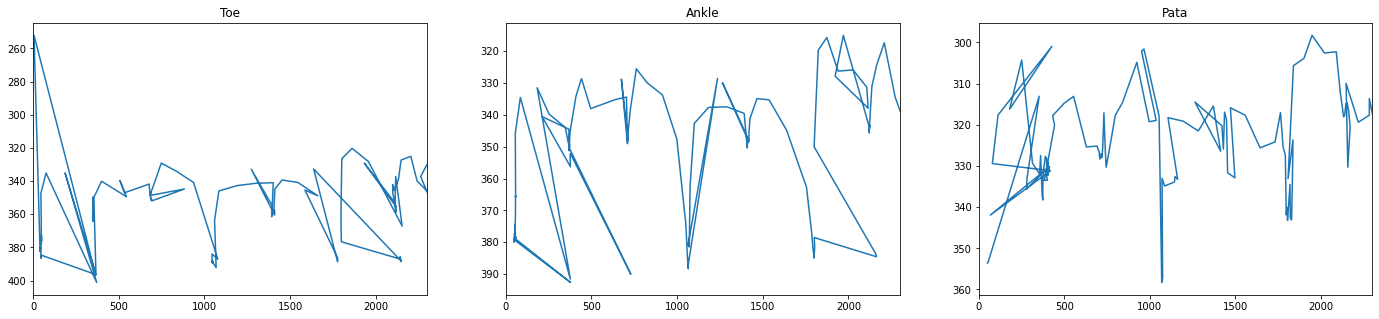

In [8]:
#TRAYECTORIA DELANTERA
plt.figure(figsize=(24,5))

plt.subplot(1,3,1)
plt.plot(delantera['toe1'], delantera['toe1.1'])
plt.title('Toe')
ax = plt.gca()
ax.invert_yaxis()
ax.set_xlim(0,2300)


plt.subplot(1,3,2)
plt.plot(delantera['ankle1'], delantera['ankle1.1'])
plt.title('Ankle')
ax = plt.gca()
ax.invert_yaxis()
ax.set_xlim(0,2300)


plt.subplot(1,3,3)
plt.plot(delantera['pata1'], delantera['pata1.1'])
plt.title('Pata')
ax = plt.gca()
ax.invert_yaxis()
ax.set_xlim(0,2300)




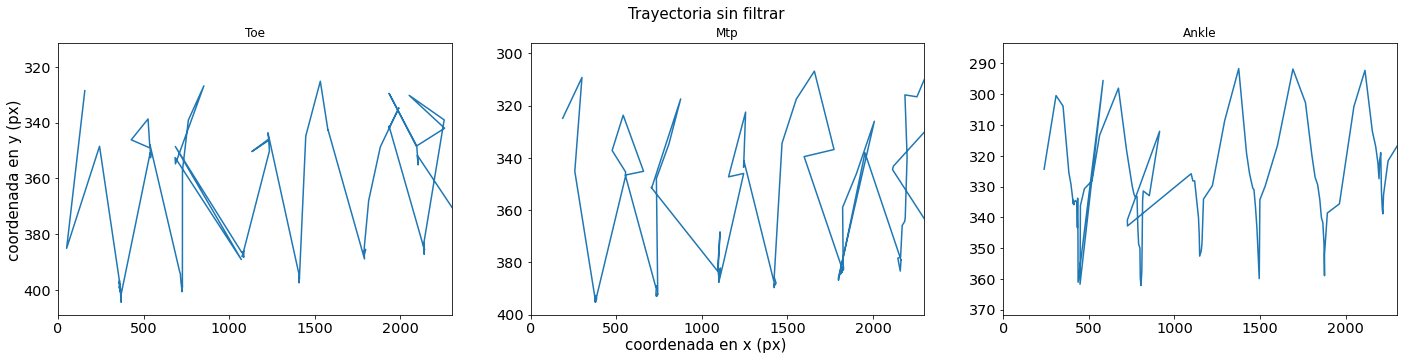

In [9]:
#TRAYECTORIA TRASERA
fig=plt.figure(figsize=(24,5))
fig.text(0.5, 0.04, 'coordenada en x (px)', ha='center', va='center',fontsize=15)
fig.text(0.1, 0.5, 'coordenada en y (px)', ha='center', va='center', rotation='vertical',fontsize=15)
plt.suptitle('Trayectoria sin filtrar',fontsize=15)

plt.subplot(1,3,1)
plt.plot(trasera['toe2'], trasera['toe2.1'])
plt.title('Toe')
ax = plt.gca()
ax.invert_yaxis()
ax.set_xlim(0,2300)
ax.tick_params(labelsize='x-large')



plt.subplot(1,3,2)
plt.plot(trasera['mtp2'], trasera['mtp2.1'])
plt.title('Mtp')
ax = plt.gca()
ax.invert_yaxis()
ax.set_xlim(0,2300)
ax.tick_params(labelsize='x-large')



plt.subplot(1,3,3)
plt.plot(trasera['ankle2'], trasera['ankle2.1'])
plt.title('Ankle')
ax = plt.gca()
ax.invert_yaxis()
ax.set_xlim(0,2300)
ax.tick_params(labelsize='x-large')



#plt.subplot(1,4,4)
#plt.plot(trasera['pata2'], trasera['pata2.1'])
#plt.title('Leg')
#ax = plt.gca()
#ax.invert_yaxis()
#ax.set_xlim(0,2300)
#ax.tick_params(labelsize='x-large')


In [10]:
#PROBANDO FILTRADO
import math
likelihood = pd.read_csv("C:\\Users\\ainho\\OneDrive\\Escritorio\\UPM4\\TFG\\mi_codigo\\testing\\"+fase+"\\"+str(csv), usecols = [10,11,12], skiprows=1)
th = 0.6
index = []
for rows in likelihood['toe2.2']:
    if (isinstance(rows,str)):
         continue
    if (math.isclose(rows, th, abs_tol = 1.0) or (rows < th)):
        index.append()
print(index)       




[]


Aplicamos el filtro a las graficas


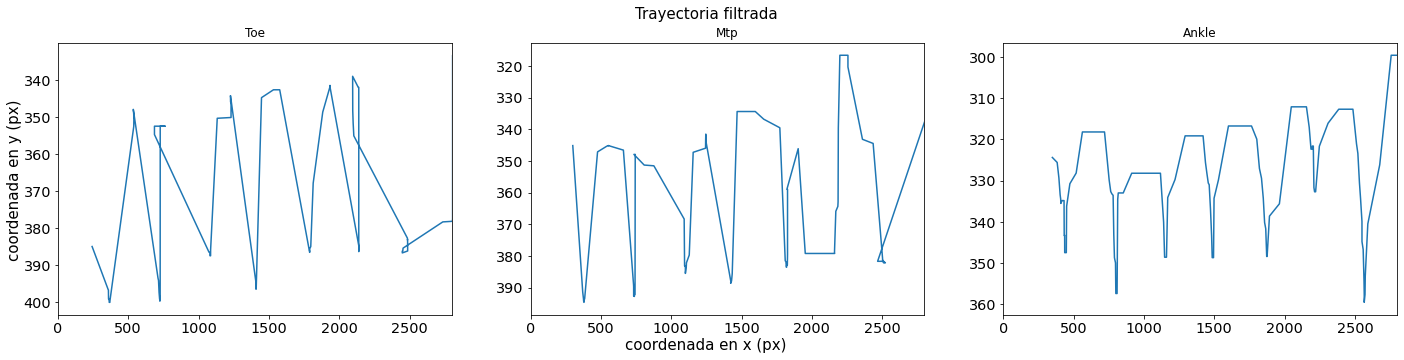

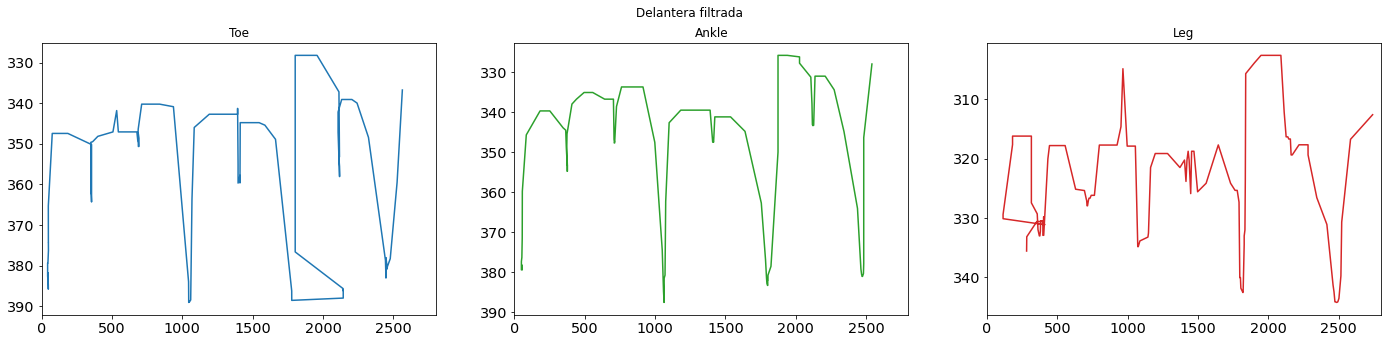

In [11]:
#GRAFICAS FILTRADAS
def filt(df,bdp,w):
    #APLICAMOS FILTRO MEDIANA
    window = w
    filtered = pd.DataFrame()
    filtered[bdp] = df[bdp].rolling(window).median()
    filtered[bdp+'.1'] = df[bdp+'.1'].rolling(window).median()

    #FILTRAMOS VALORES IMPOSIBLES
    filtered.dropna()
    eliminar = []
    for ind in filtered.index:
        valor_y = filtered.at[ind,bdp+'.1']
        if (math.isclose(valor_y,250,abs_tol = 1.0) or (valor_y < 250)):
            eliminar.append(ind) 
        if (math.isclose(valor_y,410,abs_tol = 1.0) or (valor_y > 410)):
            eliminar.append(ind)     
        
    filtered.loc[(filtered!=0).any(axis=1)]
    filtered.drop(eliminar,inplace=True)

    return(filtered)
    

print('Aplicamos el filtro a las graficas')


fig = plt.figure(figsize=(24,5))
fig.text(0.5, 0.04, 'coordenada en x (px)', ha='center', va='center',fontsize=15)
fig.text(0.1, 0.5, 'coordenada en y (px)', ha='center', va='center', rotation='vertical',fontsize=15)
plt.suptitle('Trayectoria filtrada',fontsize=15)
plt.subplot(1,3,1)
plt.plot(filt(trasera,'toe2',w)['toe2'], filt(trasera,'toe2',w)['toe2.1'])
plt.title('Toe')
ax = plt.gca()
ax.invert_yaxis()
ax.set_xlim(0,2800)
ax.tick_params(labelsize='x-large')




plt.subplot(1,3,2)
plt.plot(filt(trasera,'mtp2',w)['mtp2'], filt(trasera,'mtp2',w)['mtp2.1'])
plt.title('Mtp')
ax = plt.gca()
ax.invert_yaxis()
ax.set_xlim(0,2800)
ax.tick_params(labelsize='x-large')


plt.subplot(1,3,3)
plt.plot(filt(trasera,'ankle2',w)['ankle2'], filt(trasera,'ankle2',w)['ankle2.1'])
plt.title('Ankle')
ax = plt.gca()
ax.invert_yaxis()
ax.set_xlim(0,2800)
ax.tick_params(labelsize='x-large')

#plt.subplot(1,4,4)
#plt.plot(filt(trasera,'pata2',w)['pata2'], filt(trasera,'pata2',w)['pata2.1'])
#plt.title('Leg')
#ax = plt.gca()
#ax.invert_yaxis()
#ax.set_xlim(0,2800)
#ax.tick_params(labelsize='x-large')


plt.figure(figsize=(24,5))
plt.suptitle('Delantera filtrada')
plt.subplot(1,3,1)
plt.plot(filt(delantera,'toe1',w)['toe1'], filt(delantera,'toe1',w)['toe1.1'])
plt.title('Toe')
ax = plt.gca()
ax.invert_yaxis()
ax.set_xlim(0,2800)
ax.tick_params(labelsize='x-large')


plt.subplot(1,3,2)
plt.plot(filt(delantera,'ankle1',w)['ankle1'], filt(delantera,'ankle1',w)['ankle1.1'], 'tab:green')
plt.title('Ankle')
ax = plt.gca()
ax.invert_yaxis()
ax.set_xlim(0,2800)
ax.tick_params(labelsize='x-large')


plt.subplot(1,3,3)
plt.plot(filt(delantera,'pata1',w)['pata1'], filt(delantera,'pata1',w)['pata1.1'], 'tab:red')
plt.title('Leg')
ax = plt.gca()
ax.invert_yaxis()
ax.set_xlim(0,2800)
ax.tick_params(labelsize='x-large')




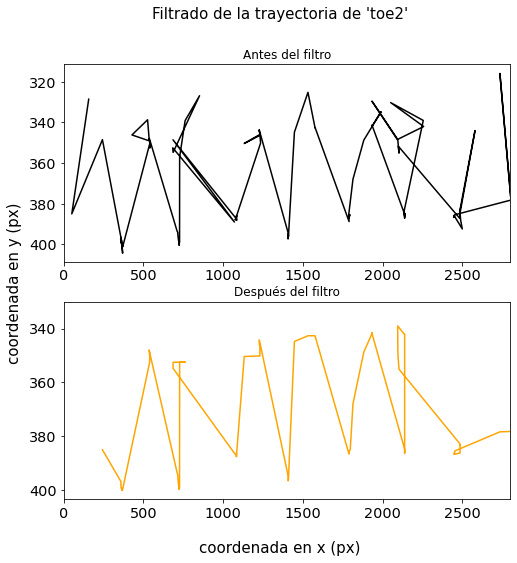

In [12]:
fig = plt.figure(figsize=(8,8))
fig.text(0.5, 0.04, 'coordenada en x (px)', ha='center', va='center',fontsize=15)
fig.text(0.04, 0.5, 'coordenada en y (px)', ha='center', va='center', rotation='vertical',fontsize=15)
plt.suptitle('Filtrado de la trayectoria de \'toe2\'',fontsize=15)
plt.subplot(2,1,1)
plt.plot(trasera['toe2'], trasera['toe2.1'],color='black')
plt.title('Antes del filtro')
ax = plt.gca()
ax.invert_yaxis()
ax.set_xlim(0,2800)
ax.tick_params(labelsize='x-large')

plt.subplot(2,1,2)
plt.plot(filt(trasera,'toe2',w)['toe2'], filt(trasera,'toe2',w)['toe2.1'],color='orange')
plt.title('Después del filtro')
ax = plt.gca()
ax.invert_yaxis()
ax.set_xlim(0,2800)
ax.tick_params(labelsize='x-large')

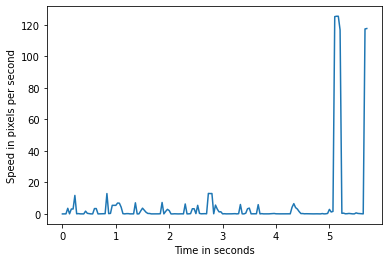

In [13]:
#CALCULO VELOCIDADES (roi)
from roi import time_in_each_roi #the function needs to be in the same folder as the notebook

#let's calculate velocity of the snout
bpt='toe2'
vel = time_in_each_roi.calc_distance_between_points_in_a_vector_2d(np.vstack([Dataframe[DLCscorer][bpt]['x'].values.flatten(), Dataframe[DLCscorer][bpt]['y'].values.flatten()]).T)

fps=30 # frame rate of camera in those experiments
time=np.arange(len(vel))*1./fps
vel=vel #notice the units of vel are relative pixel distance [per time step]

# store in other variables:
xsnout=Dataframe[DLCscorer][bpt]['x'].values
ysnout=Dataframe[DLCscorer][bpt]['y'].values
vsnout=vel

plt.plot(time,vel*1./fps)
plt.xlabel('Time in seconds')
plt.ylabel('Speed in pixels per second')
plt.show()

Values Range: 255 0
Shape de la Imagen importada: (500, 3840, 3)


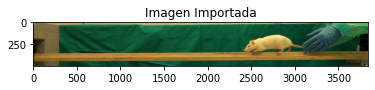

Shape de imagen recortada: (200, 500)
Shape de la mascara: (200, 500)
Punto 1 (10, 54) | Punto 2 (490, 52)
Anchura de la barra (pixeles): 90
El valor de la pendiente de la recta es: -0.004166666666666667
54.041666666666664
Recta Shape: (500,)


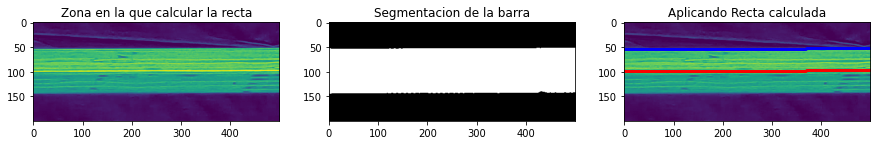

El valor de la pendiente de la recta es: -0.004166666666666667
356.125


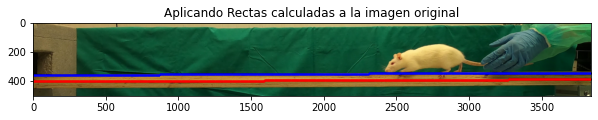

El valor de n_top es: 401


In [14]:
#OBTENEMOS UMBRALES
## --- MODIFICA LA IMAGEN QUE QUIERES USAR
#img_name = "103.png"
## ---------------------------------------

# Cargamos la Imagen
rows = 1; colums = 3
img_raw = Image.open(f'C:\\Users\\ainho\\OneDrive\\Escritorio\\UPM4\\TFG\\mi_codigo\\testing\\'+fase+"\\"+img_name)
img_raw = np.array(img_raw)
plt.title("Imagen Importada")
print("Values Range:", np.max(img_raw), np.min(img_raw))
print("Shape de la Imagen importada:", img_raw.shape)
plt.imshow(img_raw); plt.show()

# Seleccionamos la zona de interes
x_start = 500; x_end = 1000
y_start = 300; y_end = 500
img = img_raw[y_start:y_end,x_start:x_end,0]
print("Shape de imagen recortada:", img.shape)
plt.figure(figsize=(15,5))
plt.subplot(rows,colums,1)
plt.title("Zona en la que calcular la recta")
plt.imshow(img)

# Segmentamos el palo
mask = seg.chan_vese(
    img, mu=100, lambda1=100, lambda2=100, tol=1e-3,
    max_num_iter=40, dt=1, init_level_set="checkerboard",
    extended_output=False
)
print("Shape de la mascara:", mask.shape)

# -- Calculamos propiedades del palo
# Punto inicial y final para interpolar la recta
x1 = 10; x2 = mask.shape[1]-x1
first_colum = mask[:, 10]
last_colum = mask[:, x2]
y1 = np.where(first_colum == 1)[0][0]
y2 = np.where(last_colum == 1)[0][0]
p1 = (x1,y1); p2 = (x2,y2)
print("Punto 1", p1, "| Punto 2", p2)
# Anchura en pixeles
width1 = np.where(first_colum[y1+1:] == 0)[0][0]
width2 = np.where(last_colum[y2+1:] == 0)[0][0]
stick_width = round((width1+width2)/2)
print("Anchura de la barra (pixeles):", stick_width)

plt.subplot(rows,colums,2)
plt.title("Segmentacion de la barra")
plt.imshow(mask, cmap='gray')

# -- Calculamos la recta y la aplicamos sobre las imagenes
class Recta():
    
    def __init__(self, p1:tuple, p2:tuple) -> None:
        x1, y1 = p1
        x2, y2 = p2
        m = (y2-y1)/(x2-x1); n = y1 - (x1*m)
        self.m = m
        print('El valor de la pendiente de la recta es:',m)
        self.n = n
        print(n)
        
    
    def get_y(self, x:np.ndarray):
        return np.around((x*self.m) + self.n).astype(np.uint16)
    
recta_umbral = Recta(p1,p2)

x_recta = np.arange(start=0, stop=mask.shape[1], step=1)
print("Recta Shape:", x_recta.shape)
assert x_recta.shape[0] == mask.shape[1]
y_recta1 = recta_umbral.get_y(x_recta)

y_recta2 = y_recta1+round(stick_width/2) #aqui

plt.subplot(rows,colums,3)
plt.title("Aplicando Recta calculada")
plt.imshow(img)
plt.scatter(x_recta, y_recta1, color='blue', s=2) #aqui
plt.scatter(x_recta, y_recta2, color='red', s=2)
plt.show()

# -- Extrapolamos rectas a la imagen original
x1_big = x_start + x1; y1_big = y_start + y1  
x2_big = x_start + x2; y2_big = y_start + y2
p1_big = (x1_big, y1_big); p2_big = (x2_big, y2_big)
recta_umbral_big = Recta(p1_big, p2_big)
x_recta_big = np.arange(start=0, stop=img_raw.shape[1], step=1)
#y_recta_big1 = recta_umbral_big.get_y(x_recta_big)
y_recta_big1_mod = recta_umbral_big.get_y(x_recta_big) 

y_recta_big2 = y_recta_big1_mod+round(stick_width/2)  #aqui
plt.figure(figsize=(10,5))
plt.title("Aplicando Rectas calculadas a la imagen original")
plt.imshow(img_raw)
plt.scatter(x_recta_big, y_recta_big1_mod, color='blue', s=0.2) #top #aqui
plt.scatter(x_recta_big, y_recta_big2, color='red', s=0.2) #bottom
plt.show()
print('El valor de n_top es:',y_recta_big2[0])

(0.0, 3500.0)

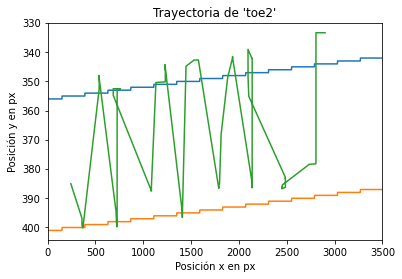

In [15]:
plt.plot(x_recta_big,y_recta_big1_mod,x_recta_big,y_recta_big2,filt(trasera,'toe2',w)['toe2'], filt(trasera,'toe2',w)['toe2.1'])
plt.title('Trayectoria de \'toe2\'')
ax = plt.gca()
ax.invert_yaxis()
ax.set_xlabel('Posición x en px')
ax.set_ylabel('Posición y en px')
ax.set_xlim(0,3500)


In [16]:
#RATIO UMBRAL
m_th=recta_umbral_big.m
n_th = recta_umbral_big.n
outlier = []
normal = []
bdp = filt(trasera,'toe2',w).dropna()
for ind in bdp.index:
    valor_x = bdp.at[ind,'toe2']
    valor_y = bdp.at[ind,'toe2.1']
    y_th = m_th*valor_x + n_th
    if (math.isclose(valor_y,y_th,abs_tol = 1.0) or (valor_y > y_th)):
    #if(int(valor_y) >= int(y_th)):
        outlier.append(valor_x)
    elif (int(valor_y) < int(y_th)):
        normal.append(valor_x)
    else:
        continue

#porcentaje top
top = len(normal)/len(bdp.index)
print('porcentaje posición en top (%)',top*100)

#porcentaje top
bottom = len(outlier)/len(bdp.index)
print('porcentaje posición en bottom (%)',bottom*100)

ratio = len(outlier)/len(normal)
print('El ratio es',ratio,'--> Valor proporcional al déficit')


porcentaje posición en top (%) 23.4375
porcentaje posición en bottom (%) 76.5625
El ratio es 3.2666666666666666 --> Valor proporcional al déficit


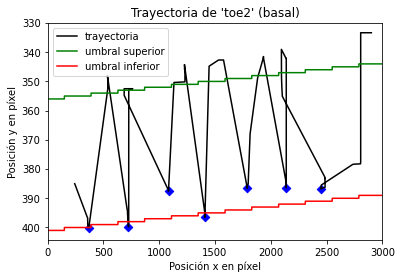

7


In [17]:
ax = plt.gca()
x_values = filt(trasera,'toe2',w)['toe2'].reset_index(drop=True)
y_values = filt(trasera,'toe2',w)['toe2.1'].reset_index(drop=True)


peaks= find_peaks(y_values, height=n_th, prominence=14)
peak_height = peaks[1]['peak_heights']
peak_pos = x_values[peaks[0]]


ax.plot(x_values,y_values,color='black',label='trayectoria')
ax.scatter(peak_pos, peak_height, color = 'b', marker = 'D')
ax.plot(x_recta_big,y_recta_big1_mod,color='green',label='umbral superior')
ax.plot(x_recta_big,y_recta_big2,color='red',label='umbral inferior')
ax.invert_yaxis()
plt.title('Trayectoria de \'toe2\' (basal)')
ax.set_xlim(0,3000)
ax.set_xlabel('Posición x en píxel')
ax.set_ylabel('Posición y en píxel')
ax.legend(loc=2)
plt.show()

pisadas = len(peak_pos)
print(pisadas)


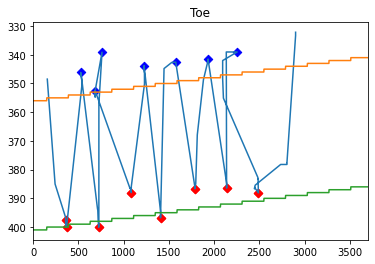

8


In [18]:
#pasos totales
ax = plt.gca()
w = 3
x_values = filt(trasera,'toe2',w)['toe2'].reset_index(drop=True)
y_values = filt(trasera,'toe2',w)['toe2.1'].reset_index(drop=True)


y = y_values*-1
minima = find_peaks(y, distance=1, prominence=1)
min_pos = x_values[minima[0]]
min_height = y[minima[0]]

peaks= find_peaks(y_values, height=0, distance = 10)
peak_height = peaks[1]['peak_heights']
peak_pos = x_values[peaks[0]]


ax.plot(x_values,y_values)
ax.scatter(peak_pos, peak_height, color = 'r', marker = 'D')
ax.scatter(peak_pos, peak_height, color = 'r', marker = 'D')
ax.scatter(min_pos, min_height*-1, color = 'b', marker = 'D')
ax.plot(x_recta_big,y_recta_big1_mod,x_recta_big,y_recta_big2)
ax.invert_yaxis()
plt.title('Toe')
ax.set_xlim(0,3700)
plt.show()

pisadas_totales = len(peak_pos)
print(pisadas_totales)



In [19]:
from openpyxl import Workbook
from openpyxl import load_workbook


wb = load_workbook('./output.xlsx')
sheet = wb[fase]
puntero = sheet.max_row + 1
sheet['A'+str(puntero)] = rata
sheet['B'+str(puntero)] = '%top'
sheet['C'+str(puntero)] = top
sheet['B'+str(puntero+1)] = '%\\bottom'
sheet['C'+str(puntero+1)] = bottom
sheet['B'+str(puntero+2)] = '%\\ratio'
sheet['C'+str(puntero+2)] = ratio
sheet['B'+str(puntero+3)] = 'pisadas'
sheet['C'+str(puntero+3)] = pisadas
sheet['B'+str(puntero+4)] = 'totales'
sheet['C'+str(puntero+4)] = pisadas_totales

wb.save('./output.xlsx')

